In [1]:
# import required modules
%cd /home/gridsan/lchan/git-remotes/polychrom_analysis
import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from post_processing.visualization import *
from post_processing.analysis import *
from post_processing.compscores import *
from post_processing.msd import *

import random
import csv
import math
from scipy.stats import rv_continuous

import nglutils as ngu
import nglview as nv

/home/gridsan/lchan/git-remotes/polychrom_analysis


In [ ]:
# for visualization of polymer
%load_ext autoreload
%autoreload 2

In [6]:
# make artifical chromosome 21, functions
global mean_a, mean_b # make sure to change!
mean_a = 200
mean_b = 25

def write_artificial_to_csv(filepath, ids):
    # filepath is path with name of csv file
    # ids is array-like with 1s and 0s
    with open(filepath, 'w') as f:
        writer = csv.writer(f)
        for i in ids:
            if i==1:
                writer.writerow('A')
            else:
                writer.writerow('B')
    
def plot_chromosome(ids, name='Artificial chromosome'):
    # ids is array-like, contains N values of either 1 or 0 corresponding to A and B monomers respectively
    data = ids.reshape(1, 1302)
    plt.imshow(data, cmap='Reds', aspect=50)
    plt.grid(False)
    plt.yticks([], [])
    plt.xlabel(name)
    plt.show()
    
class exp_dist_a(rv_continuous): 
    '''Penalized exponential distribution with mean A'''
    def _pdf(self, x): 
        return x * np.exp(-x / mean_a)
    
class exp_dist_b(rv_continuous): 
    '''Penalized exponential distribution with mean B'''
    def _pdf(self, x): 
        return x * np.exp(-x / mean_b)
    
def design_blocks(chr_stats, num_try=1):
    # N is number of monomers, chr_stats is output of calculate_chr_stats
    # accept any artificial chromosome of size N whose last block is less than 1std away; otherwise, restart
    # return array-like of ones and zeros
    mean_a = chr_stats[0]
    stdevA = chr_stats[1]
    mean_b = chr_stats[2]
    stdevB = chr_stats[3]
    numA = chr_stats[4]
    numB = chr_stats[5]
    N = numA+numB
    
    # generate distributions
    dist_a = exp_dist_a(name = 'pseudo-exponential a') 
    p_a = np.array([dist_a._pdf(x) for x in np.arange(0, N)]) # set min and max to non-zero and non-max
    p_a /= p_a.sum()
    dist_b = exp_dist_b(name = 'pseudo-exponential b')
    p_b = np.array([dist_b._pdf(x) for x in np.arange(0, N)])
    p_b /= p_b.sum()
    
    flagA = True # True if next block is A
    # initialize starting block identity and length
    prob_start = np.ones(mean_a)
    prob_start = np.append(prob_start, np.zeros(mean_b))
    choose = random.choice(prob_start)
    if (choose == 1):
        y_val_a = np.random.choice(np.arange(0, N), p=p_a, replace=False)
        chromo = np.ones(round(y_val_a))
        flagA = False
    else:
        y_val_b = np.random.choice(np.arange(0, N), p=p_b, replace=False)
        chromo = np.zeros(round(y_val_b))
        flagA = True
    # continue adding blocks until bigger than N monomers
    while (len(chromo) < N):
        if (flagA):
            y_val_a = np.random.choice(np.arange(0, N), p=p_a, replace=False)
            recent_add = np.ones(round(y_val_a))
            chromo = np.append(chromo, recent_add)
            flagA = False
        else:
            y_val_b = np.random.choice(np.arange(0, N), p=p_b, replace=False)
            recent_add = np.zeros(round(y_val_b))
            chromo = np.append(chromo, recent_add)
            flagA = True
    space_to_end = N - len(chromo) + len(recent_add)
    if (flagA): # if truncating last B block is within acceptable limits
        chromo = chromo[0:N]
        if (np.count_nonzero(chromo == 1) == numA):
            return chromo
        else:
            if (num_try % 100 == 0):
                print(f'{num_try} attempt failed due to incorrect A composition of {np.count_nonzero(chromo == 1)}. Retrying')
            return design_blocks(chr_stats, num_try+1)
    elif (not flagA):
        chromo = chromo[0:N]
        if (np.count_nonzero(chromo == 1) == numA):
            return chromo
        else:
            if (num_try % 100 == 0):
                print(f'{num_try} attempt failed due to incorrect A composition of {np.count_nonzero(chromo == 1)}. Retrying')
            return design_blocks(chr_stats, num_try+1)
    else: # last block is out of range
        if (num_try % 100 == 0):
            print(f'{num_try} attempt failed due to being out of range. Retrying')
        return design_blocks(chr_stats, num_try+1)

def calculate_chr_stats(path):
    # path is path to csv file of AB identities
    # returns tuple of size 5 with elements (meanA, stdevA, meanB, stdevB, N)
    ABids = np.loadtxt(path, dtype=str)
    ids = (ABids == "A").astype(int)
    numA = np.count_nonzero(ids == 1)
    numB = np.count_nonzero(ids == 0)
    # find sizes of all blocks
    A_blocks = []
    B_blocks = []
    curr_block_length = 1
    for i in range(len(ids)-1):
        if (ids[i+1] == ids[i]): # if next monomer is the same
            curr_block_length+= 1
            if (i == len(ids)-2): # if end of chromosome
                if (ids[i] == 1):
                    A_blocks.append(curr_block_length)
                else:
                    B_blocks.append(curr_block_length)
        else: # if block ends
            if (ids[i] == 1):
                A_blocks.append(curr_block_length)
            else:
                B_blocks.append(curr_block_length)
            curr_block_length = 1
    return (round(np.mean(A_blocks)), round(np.std(A_blocks)), round(np.mean(B_blocks)), round(np.std(B_blocks)), numA, numB)

def design_blocky_chr(blocksize_A, blocksize_B, N):
    # where blocksize corresponds to number of monomers per block. alternates between A and B.
    # N is number of total monomers. last block will be cut-off.
    # return array-like 0s and 1s
    
    flagA = True # True if next block is A
    # initialize starting block identity and length
    prob_start = np.ones(mean_a)
    prob_start = np.append(prob_start, np.zeros(mean_b))
    choose = random.choice(prob_start)
    if (choose == 1):
        chromo = np.ones(round(blocksize_A))
        flagA = False
    else:
        chromo = np.zeros(round(blocksize_B))
        flagA = True
    # continue adding blocks until bigger than N monomers
    while (len(chromo) < N):
        if (flagA):
            recent_add = np.ones(round(blocksize_A))
            chromo = np.append(chromo, recent_add)
            flagA = False
        else:
            recent_add = np.zeros(round(blocksize_B))
            chromo = np.append(chromo, recent_add)
            flagA = True
    chromo = chromo[0:N]
    return chromo

def design_simple_chr():
    # N is number of total monomers, i.e. 1302
    # generate a chromosome with half A and half B, where B sandwiches A (300 B, 601 A, 301 B)
    chromo = np.zeros(325)
    chromo = np.append(chromo, np.ones(651))
    chromo = np.append(chromo, np.zeros(326))
    return chromo

In [ ]:
# design artificial chromosomes
#tup = calculate_chr_stats("data/ABidentities_chr21_Su2020_2perlocus.csv") # 118. 71. 207. 178. 474. 828
#tup = (25, 71, 200, 178, 474, 828)
#ids = design_blocks(tup)
ids = design_blocky_chr(200, 25, 1302)
write_artificial_to_csv(r'data/ABidentities_chr21_Su2020_blocky4.csv', ids.tolist())
plot_chromosome(ids, name='Blocky 4')

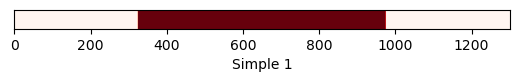

In [7]:
ids = design_simple_chr()
write_artificial_to_csv(r'data/ABidentities_chr21_Su2020_simple1.csv', ids.tolist())
plot_chromosome(ids, name = 'Simple 1')

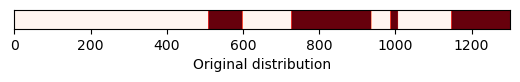

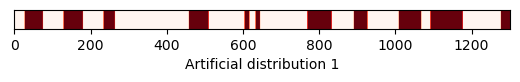

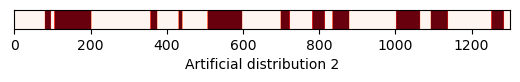

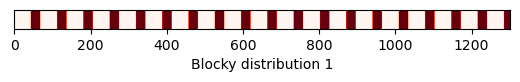

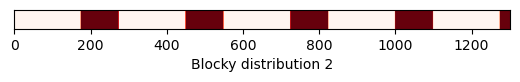

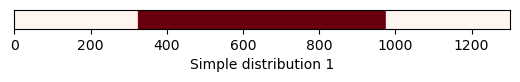

In [8]:
# visualize various artificial chromosomesABids = np.loadtxt("data/ABidentities_chr21_Su2020_blocky6.csv", dtype=str)
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str)
ABids1 = np.loadtxt("data/ABidentities_chr21_Su2020_artificial1.csv", dtype=str)
ABids2 = np.loadtxt("data/ABidentities_chr21_Su2020_artificial2.csv", dtype=str)
ABids4 = np.loadtxt("data/ABidentities_chr21_Su2020_blocky1.csv", dtype=str)
ABids5 = np.loadtxt("data/ABidentities_chr21_Su2020_blocky2.csv", dtype=str)
ABids6 = np.loadtxt("data/ABidentities_chr21_Su2020_simple1.csv", dtype=str)
ids = (ABids == "A").astype(int)
ids1 = (ABids1 == "A").astype(int)
ids2 = (ABids2 == "A").astype(int)
ids4 = (ABids4 == "A").astype(int)
ids5 = (ABids5 == "A").astype(int)
ids6 = (ABids6 == "A").astype(int)

plot_chromosome(ids, name='Original distribution')
plot_chromosome(ids1, name='Artificial distribution 1')
plot_chromosome(ids2, name='Artificial distribution 2')
plot_chromosome(ids4, name='Blocky distribution 1')
plot_chromosome(ids5, name='Blocky distribution 2')
plot_chromosome(ids6, name='Simple distribution 1')

In [17]:
timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*4000), 100))
timepoints = list(timepoints.astype(int))
print(timepoints)
ntimepoints=100
mint=100
maxt=10000*4000
prev_time = mint-15
new_timepoints = []
for i in range(len(timepoints)):
    time_diff = timepoints[i] - prev_time
    rounded_step = round(time_diff/12)
    if (rounded_step > 1000):
        rounded_step = 1000
    ith_window = [timepoints[i] - 5*rounded_step, timepoints[i] - 4*rounded_step, timepoints[i] - 3*rounded_step, timepoints[i] - 2*rounded_step, timepoints[i] - rounded_step, timepoints[i], timepoints[i] + rounded_step, timepoints[i] + 2*rounded_step,
                    timepoints[i] + 3*rounded_step, timepoints[i] + 4*rounded_step, timepoints[i] + 5*rounded_step]
    new_timepoints.extend(ith_window)
    prev_time = timepoints[i]
#new_tp = new_timepoints[0:1100:25] # modify to match above
#new_tp[0] # look at scrollbar, outputs timestep #
#new_timepoints[-100:-1]

[100, 114, 130, 148, 168, 192, 219, 249, 284, 323, 368, 419, 478, 544, 620, 706, 804, 916, 1044, 1189, 1354, 1543, 1758, 2002, 2281, 2598, 2960, 3372, 3841, 4375, 4984, 5678, 6468, 7368, 8393, 9562, 10892, 12408, 14135, 16102, 18343, 20895, 23803, 27116, 30889, 35188, 40085, 45663, 52018, 59257, 67503, 76897, 87598, 99789, 113676, 129496, 147517, 168046, 191432, 218073, 248421, 282992, 322375, 367238, 418344, 476563, 542884, 618434, 704498, 802539, 914224, 1041451, 1186384, 1351487, 1539566, 1753819, 1997889, 2275924, 2592652, 2953457, 3364474, 3832689, 4366064, 4973665, 5665823, 6454305, 7352516, 8375725, 9541329, 10869144, 12381744, 14104844, 16067738, 18303798, 20851037, 23752763, 27058306, 30823863, 35113452, 40000000]
